In [1]:
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00542/log2.csv

--2022-03-10 10:47:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00542/log2.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2876998 (2.7M) [application/x-httpd-php]
Saving to: ‘log2.csv’

log2.csv            100%[===================>]   2.74M  2.65MB/s    in 1.0s    

2022-03-10 10:47:13 (2.65 MB/s) - ‘log2.csv’ saved [2876998/2876998]



In [2]:
!pip install feature_engine

     |████████████████████████████████| 205 kB 243 kB/s            


## Objetivos

Vamos a construir un modelo de clasificación multiclase mediante redes neuronales en tensorflow que permita identificar la naturaleza peligrosa o no del firewall.

In [3]:
##IMPORTS 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import OneHotEncoder as Ohe

from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
%load_ext tensorboard

## Preparación y visualización de los datos

In [5]:
data=pd.read_csv('../input/internet-firewall-data-set/log2.csv')
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
df=data.copy()
df.tail()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0
65531,54867,445,0,0,drop,70,70,0,1,0,1,0


Observemos el target:

<AxesSubplot:>

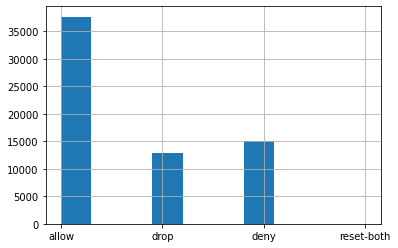

In [7]:
df["Action"].hist()

Viendo como se distribuye se hará casi imposible una buena clasificación para reset-both, pero para las demás categorías sí que será posible.

In [8]:
columnas=data.columns.values.tolist()
print(columnas)

['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']


Vamos a crear una red neuronal por lo que viendo el dataset, podemos empezar a marcarnos objetivos.


En primer lugar debemos tener en cuenta los outliers ya que las redes neuronales si tenemos demasiado outliers nos puede perjudicar. 
Por otro lado tenemos datos numéricos y categóricos, por lo que habrá que acabar escalando porque las redes de neuronas también son sensibles

In [9]:
#Observamos rápidamente si hay valores faltantes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


### Tipos de variables

Observamos que disponemos de dos tipos de variables. 

Por un lado tenemos las variables categóricas que son Source Port, Destination Port, NAT Source Port, NAT Destination Port. 

Por otro lado vemos las variables numéricas que son las relacionadas con los bytes, los paquetes y el tiempo de repuesta.

#### Categóricas

Respecto a las variables categóricas vamos a crear categorías raras y después haremos codificación por la frecuencia para poder cuando trabajemos con las numéricas normalizar y estandarizar todas las columnas.

In [10]:
cat=['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

In [11]:
y=[]
for x in cat:
  print("\n",x)
  y.append(data[x].value_counts()/len(data[x]))
  print("\n",y[-1])


 Source Port

 58638    0.012818
27005    0.007828
443      0.004166
57470    0.003388
49418    0.003205
           ...   
32996    0.000015
60574    0.000015
60570    0.000015
65368    0.000015
54871    0.000015
Name: Source Port, Length: 22724, dtype: float64

 Destination Port

 53       0.235213
445      0.196713
443      0.178295
80       0.061573
25174    0.016587
           ...   
20009    0.000015
48608    0.000015
10016    0.000015
13384    0.000015
22455    0.000015
Name: Destination Port, Length: 3273, dtype: float64

 NAT Source Port

 0        0.433864
48817    0.001267
58638    0.000778
50116    0.000229
7986     0.000076
           ...   
2063     0.000015
33661    0.000015
36797    0.000015
14122    0.000015
13485    0.000015
Name: NAT Source Port, Length: 29152, dtype: float64

 NAT Destination Port

 0        0.433864
53       0.230330
443      0.178203
80       0.061466
27015    0.003571
           ...   
45561    0.000015
45738    0.000015
41872    0.000015
25760  

Observando esto, podemos llegar a la conclusión de que la variable SourcePort presenta 22.000 casos diferentes que es alrededor de 1/3 del total de datos de los cuales la categoría más común presenta un 1% de los casos. 

Dicho esto creo que la columna tiene un nulo valor predictivo por lo que la vamos a desechar.

In [12]:
df.drop(["Source Port"],axis=1, inplace=True)
df.head()

,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,53,54587,53,allow,177,94,83,2,30,1,1
1,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [13]:
def group_rare(df, var,umbral):
    total_ = len(df)

    temp_df = pd.Series(df[var].value_counts() / total_)

    grouping_dict = {
        k: ('rare' if k not in temp_df[temp_df >= umbral].index else k)
        for k in temp_df.index
    }
    
    tmp = df[var].map(grouping_dict)

    return tmp

In [14]:
df["Dest_Port"]=group_rare(df,"Destination Port",0.05)
df["NAT_Source"]=group_rare(df,"NAT Source Port",0.05)
df["NAT_Desti"]=group_rare(df,"NAT Destination Port",0.05)

df.drop(["Destination Port","NAT Source Port", "NAT Destination Port"],axis=1, inplace=True)

#### Numéricas

                   Bytes  Bytes Sent  Bytes Received
Bytes           1.000000    0.933462        0.830225
Bytes Sent      0.933462    1.000000        0.575047
Bytes Received  0.830225    0.575047        1.000000


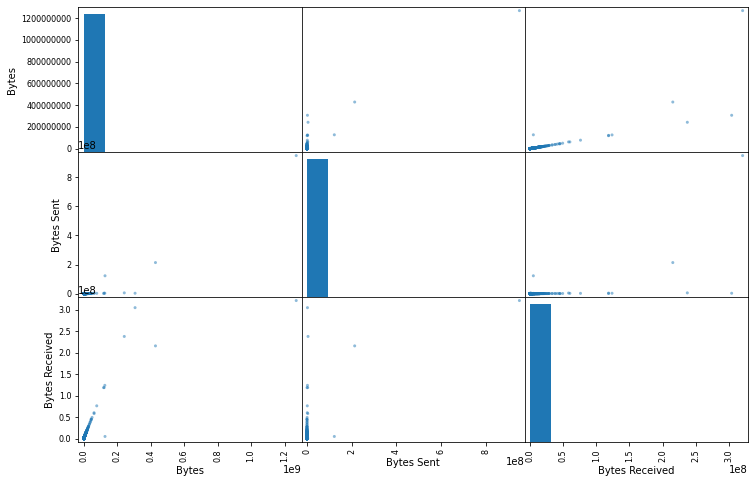

In [15]:
matrix=pd.plotting.scatter_matrix(df[['Bytes', 'Bytes Sent', 'Bytes Received']], figsize=(12,8))
print(data[['Bytes', 'Bytes Sent', 'Bytes Received']].corr())

                Packets  pkts_sent  pkts_received
Packets        1.000000   0.961286       0.916978
pkts_sent      0.961286   1.000000       0.771550
pkts_received  0.916978   0.771550       1.000000


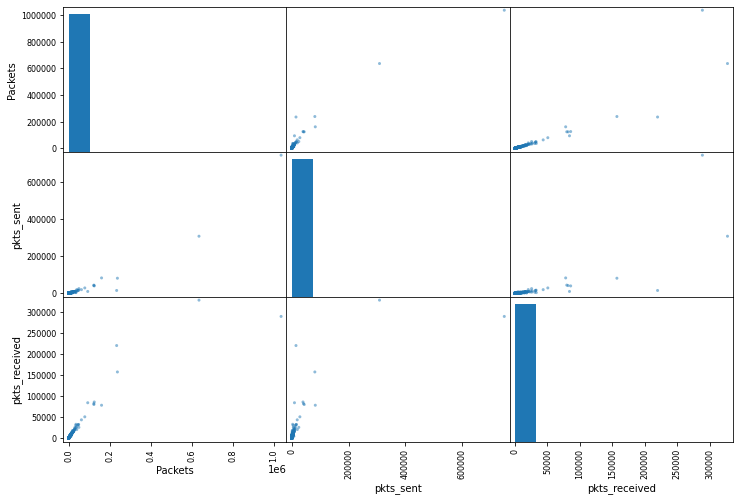

In [16]:
matrix=pd.plotting.scatter_matrix(df[['Packets',  'pkts_sent', 'pkts_received']], figsize=(12,8))
print(data[['Packets',  'pkts_sent', 'pkts_received']].corr())

Obviamente la cantidad de bytes y de paquetes totales está relacionado con los enviados y con los que han finalmente llegado. Pero las enviados con los recibidos están correlacionados pero no de manera tan clara, por lo que vamos a eliminar del dataset las variables bytes y paquetes

In [17]:
df.drop(["Bytes","Packets"],axis=1,inplace=True)

In [18]:
df.head()

,Action,Bytes Sent,Bytes Received,Elapsed Time (sec),pkts_sent,pkts_received,Dest_Port,NAT_Source,NAT_Desti
0,allow,94,83,30,1,1,53,rare,53
1,allow,1600,3168,17,10,9,rare,rare,rare
2,allow,118,120,1199,1,1,rare,rare,rare
3,allow,1438,1889,17,8,7,rare,rare,rare
4,allow,6778,18580,16,13,18,443,rare,443


##### Observación de Outliers
Vamos a ver si nuestros datos numéricos presentan muchos valores extremos

In [19]:
def diagnostic_plots(df, variable):
    # la función toma un dataframe (df) y
    # la variable de interés como argumento

    # define el tamaño de la gráfica
    plt.figure(figsize=(16, 4))

    # histograma
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # gráfica Q-Q 
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Cuantiles de la variable')

    # gráfico de caja 
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Gráfico de caja')

    plt.show()

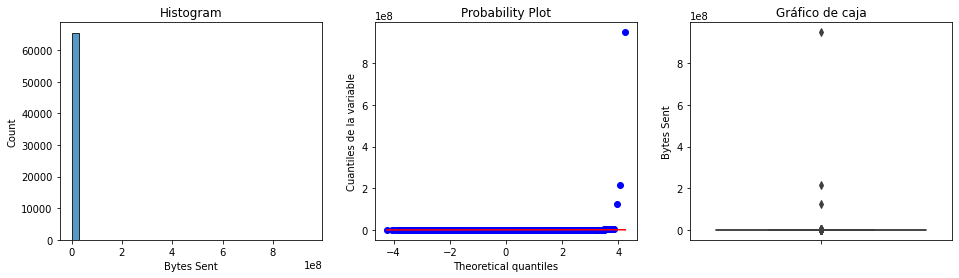

In [20]:
diagnostic_plots(df,"Bytes Sent")

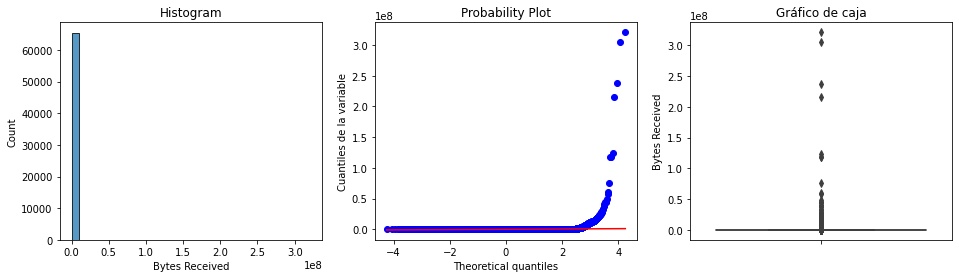

In [21]:
diagnostic_plots(df,"Bytes Received")

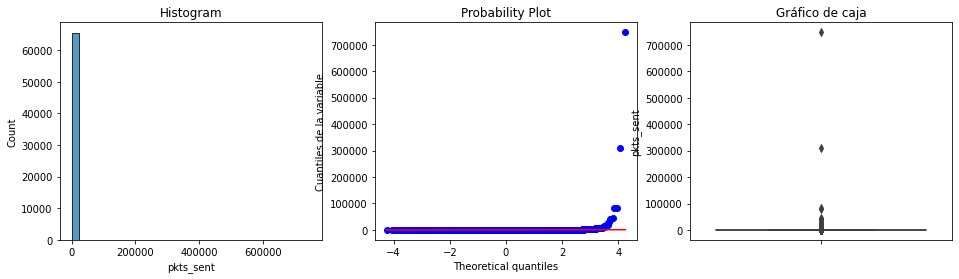

In [22]:
diagnostic_plots(df,"pkts_sent")

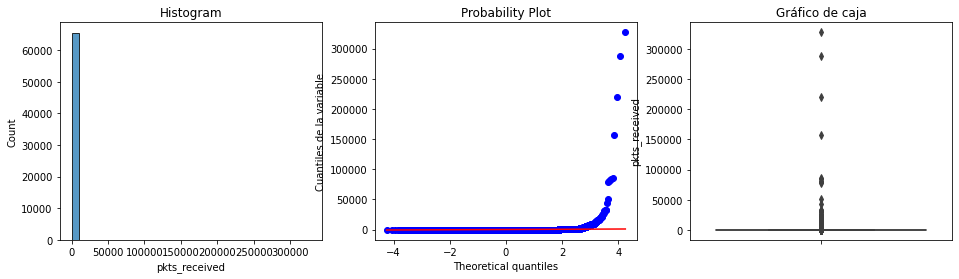

In [23]:
diagnostic_plots(df,"pkts_received")

El algoritmo de redes neuronales trabajar con valores extremos a no ser que haya muchos, como no vemos una gran cantidad de valores extremos, vamos a dejarlos.

#### Target

Vamos a codificar el target con OneHotEncoding o nos dará problemas a la hora de entrenar la red neuronal

In [24]:
#Lo haremos una vez separados los conjuntos
one_hot_encoder=Ohe(variables=["Action"])

## Separación de los conjuntos y finalización del preprocesado de datos

In [25]:
#Vamos a separar los conjuntos
x_train, x_test, Y_train, Y_test = train_test_split(df.iloc[:,1:],
                                                    df.iloc[:,:1], test_size=0.10,
                                                    random_state=9336)


In [26]:
#Codificación de las variables categóricas por frecuencia
Y_train=one_hot_encoder.fit_transform(Y_train)
Y_test=one_hot_encoder.transform(Y_test)

count_enc = CountFrequencyEncoder(
    encoding_method="frequency", 
    variables=['Dest_Port', 'NAT_Source', 'NAT_Desti'])
count_enc.fit(x_train)
x_train = count_enc.transform(x_train)
x_test = count_enc.transform(x_test)

Ahora por último valor a escalar todas las variables numéricas.

In [27]:
scaler = StandardScaler()
num=["Bytes Sent","Bytes Received","Elapsed Time (sec)",
                   "pkts_sent","pkts_received"]
# entrena el escalador en el set de entrenamiento
# aprende los parámetros 
scaler.fit(x_train[num])

# transforma los sets de entrenamiento y prueba 
x_train[num] = scaler.transform(x_train[num])
x_test[num] = scaler.transform(x_test[num])

In [28]:
#Pasamos a preparar los datos para tensorflow

#Conjunto de entrenamiento
X_train=tf.convert_to_tensor(x_train, np.float16)
y_train=tf.convert_to_tensor(Y_train,np.float16)

#Conjunto de test
X_test=tf.convert_to_tensor(x_test, np.float16)
y_test=tf.convert_to_tensor(Y_test,np.float16)

2022-03-10 10:47:56.963424: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Creación y entrenamiento del modelo

In [29]:
layers= [keras.layers.Flatten(input_shape=(8,)),
         keras.layers.Dense(32,activation=tf.nn.relu),
         keras.layers.Dense(96,activation=tf.nn.relu),
         keras.layers.Dense(192,activation=tf.nn.relu),
         keras.layers.Dense(500,activation=tf.nn.relu),
         keras.layers.Dense(4,activation=tf.nn.softmax) ]

model=keras.Sequential(layers, name="Clasificacion_multiclase")

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "Clasificacion_multiclase"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 96)                3168      
_________________________________________________________________
dense_2 (Dense)              (None, 192)               18624     
_________________________________________________________________
dense_3 (Dense)              (None, 500)               96500     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2004      
Total params: 120,584
Trainable params: 120,584
Non-trainable params: 0
____________________________________

In [30]:
tensorboard_callback= TensorBoard(log_dir="logs") 

model.fit(
    X_train,
    y_train,
    epochs=50, 
    batch_size=15000, 
    validation_split=0.05, 
    callbacks=[tensorboard_callback]
)

2022-03-10 10:47:57.932689: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-10 10:47:57.932872: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-10 10:47:57.934020: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-10 10:47:58.030034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
2/4 [==============>...............] - ETA: 0s - loss: 1.3697 - accuracy: 0.3166

2022-03-10 10:47:59.014520: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-10 10:47:59.014704: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-10 10:47:59.168480: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-10 10:47:59.174438: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-10 10:47:59.182252: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_03_10_10_47_59

2022-03-10 10:47:59.183605: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_10_10_47_59/95b79d7be3cf.trace.json.gz
2022-03-10 10:47:59.197517: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_03_10_10_47_59

2022-03-10 10:47:59.198601: I

4/4 [==============================] - 2s 247ms/step - loss: 1.3400 - accuracy: 0.4379 - val_loss: 1.2550 - val_accuracy: 0.5778
Epoch 2/50
4/4 [==============================] - 1s 155ms/step - loss: 1.2098 - accuracy: 0.5743 - val_loss: 1.1124 - val_accuracy: 0.5778
Epoch 3/50
4/4 [==============================] - 1s 153ms/step - loss: 1.0683 - accuracy: 0.5743 - val_loss: 0.9860 - val_accuracy: 0.5778
Epoch 4/50
4/4 [==============================] - 1s 159ms/step - loss: 0.9650 - accuracy: 0.5743 - val_loss: 0.9072 - val_accuracy: 0.5778
Epoch 5/50
4/4 [==============================] - 1s 151ms/step - loss: 0.8785 - accuracy: 0.5743 - val_loss: 0.8095 - val_accuracy: 0.5778
Epoch 6/50
4/4 [==============================] - 1s 149ms/step - loss: 0.7787 - accuracy: 0.5743 - val_loss: 0.7051 - val_accuracy: 0.5778
Epoch 7/50
4/4 [==============================] - 1s 147ms/step - loss: 0.6663 - accuracy: 0.5743 - val_loss: 0.5861 - val_accuracy: 0.5778
Epoch 8/50
4/4 [===============

## Evaluación y visualización de resultados


In [31]:
#Hará la evaluación según la métrica y función de loss entrenada
test_loss,test_acc= model.evaluate(X_test,y_test)
print(test_loss)
print(test_acc)

205/205 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9963
0.02114724926650524
0.9963381290435791


In [32]:
%tensorboard --logdir logs

In [33]:
report = classification_report(y_test, tf.math.round(model.predict(X_test)) )
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3756
           1       1.00      1.00      1.00      1276
           2       0.99      0.99      0.99      1517
           3       0.00      0.00      0.00         5

   micro avg       1.00      1.00      1.00      6554
   macro avg       0.75      0.75      0.75      6554
weighted avg       1.00      1.00      1.00      6554
 samples avg       1.00      1.00      1.00      6554



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusiones
Hemos hecho un buen trabajo, hemos conseguido obtener buenas métricas excepto en el apartado de macro avg pero es debido a la categoría reset-both que como vemos hemos tenido tan pocos datos de ella en el entrenamiento que luego nuestro modelo no ha sabido clasificarla correctamente. A pesar de ello hemos hecho un buen trabajo.